In [145]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Download ECG Images Dataset

In [6]:
!mkdir %userprofile%\.kaggle
!copy kaggle.json %userprofile%\.kaggle\

A subdirectory or file C:\Users\001\.kaggle already exists.


        1 file(s) copied.


In [ ]:
!kaggle datasets download -d erhmrai/ecg-image-data

# Download Heart Disease Dataset

In [8]:
!pip install ucimlrepo

  Obtaining dependency information for ucimlrepo from https://files.pythonhosted.org/packages/3e/4a/ecc3456479d687202b34ee42317c3a63e09793c9409a720052d38356431a/ucimlrepo-0.0.3-py3-none-any.whl.metadata


In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 


In [25]:
df = pd.concat([X,y],axis=1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [3]:
print(heart_disease.metadata) 

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

In [4]:
print(heart_disease.variables) 

        name     role         type demographic  \
0        age  Feature      Integer         Age   
1        sex  Feature  Categorical         Sex   
2         cp  Feature  Categorical        None   
3   trestbps  Feature      Integer        None   
4       chol  Feature      Integer        None   
5        fbs  Feature  Categorical        None   
6    restecg  Feature  Categorical        None   
7    thalach  Feature      Integer        None   
8      exang  Feature  Categorical        None   
9    oldpeak  Feature      Integer        None   
10     slope  Feature  Categorical        None   
11        ca  Feature      Integer        None   
12      thal  Feature  Categorical        None   
13       num   Target      Integer        None   

                                          description  units missing_values  
0                                                None  years             no  
1                                                None   None             no  
2              

# Data Preprocessing

## ECG Images

In [4]:
BATCH_SIZE = 128
IM_SHAPE = (224,224,3)
LEARNING_RATE = 2e-4
LATENT_DIM=100
EPOCHS=20

In [5]:
ecg_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./ecg-image-data/ECG_Image_data/train",   
    image_size=(IM_SHAPE[0], IM_SHAPE[1]), 
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 99199 files belonging to 6 classes.


In [6]:
ecg_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./ecg-image-data/ECG_Image_data/test",   
    image_size=(IM_SHAPE[0], IM_SHAPE[1]), 
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 24799 files belonging to 6 classes.


In [7]:
ecg_train_dataset.class_names

['F', 'M', 'N', 'Q', 'S', 'V']

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 2

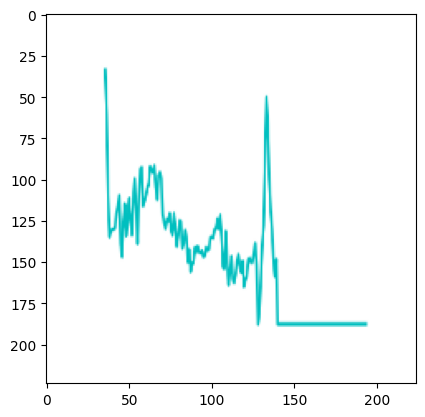

In [8]:
for x in ecg_train_dataset.unbatch():
    plt.imshow(x[0]/255)
    print(x)
    break

In [9]:
def preprocess_images(image, label):
    new_label = tf.where(label == 2, 0, 1)
    new_image = tf.cast(image, tf.float32) / 255.0
    return new_image, new_label


In [10]:
ecg_train_dataset = ecg_train_dataset.map(preprocess_images)
ecg_test_dataset = ecg_test_dataset.map(preprocess_images)

In [11]:
ecg_train_dataset

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
def separate_normal_and_abnormal(ds):
    normal_images = []
    abnormal_images = []
    for batch in ds:
        images,labels = batch
        for image,label in zip(images,labels):
            if label.numpy() == 0:
                normal_images.append(image.numpy())
            else:
                abnormal_images.append(image.numpy())
    random.shuffle(normal_images)
    random.shuffle(abnormal_images)
    return normal_images,abnormal_images


In [13]:
normal_train_images,abnormal_train_images = separate_normal_and_abnormal(ecg_train_dataset)

In [14]:
len(normal_train_images)

75709

In [15]:
len(abnormal_train_images)

23490

In [16]:
normal_test_images,abnormal_test_images = separate_normal_and_abnormal(ecg_test_dataset)

In [17]:
len(normal_test_images),len(abnormal_test_images)

(18926, 5873)

## Structured Data

In [18]:
y.value_counts()

num
0      164
1       55
2       36
3       35
4       13
Name: count, dtype: int64

In [19]:
y.loc[:,'num'] = y['num'].apply(lambda x: 1 if x in [1, 2, 3, 4] else 0)

In [20]:
y.value_counts()

num
0      164
1      139
Name: count, dtype: int64

In [21]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1)

In [22]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
94,63,0,3,135,252,0,2,172,0,0.0,1,0.0,3.0
238,49,0,2,134,271,0,0,162,0,0.0,2,0.0,3.0
114,62,0,3,130,263,0,0,97,0,1.2,2,1.0,7.0
196,69,1,1,160,234,1,2,131,0,0.1,2,1.0,3.0
209,62,0,4,150,244,0,0,154,1,1.4,2,0.0,3.0


In [23]:
y_train.head()

,num
94,0
238,0
114,1
196,0
209,1


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [27]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


In [28]:
corr = df.corr()
corr

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
age,1.000000,-0.097542,0.104139,0.284946,0.208950,0.118530,0.148868,-0.393806,0.091661,0.203805,0.161770,0.362605,0.127389,0.223120
sex,-0.097542,1.000000,0.010084,-0.064456,-0.199915,0.047862,0.021647,-0.048663,0.146201,0.102173,0.037533,0.093185,0.380936,0.276816
cp,0.104139,0.010084,1.000000,-0.036077,0.072319,-0.039975,0.067505,-0.334422,0.384060,0.202277,0.152050,0.233214,0.265246,0.414446
trestbps,0.284946,-0.064456,-0.036077,1.000000,0.130120,0.175340,0.146560,-0.045351,0.064762,0.189171,0.117382,0.098773,0.133554,0.150825
chol,0.208950,-0.199915,0.072319,0.130120,1.000000,0.009841,0.171043,-0.003432,0.061310,0.046564,-0.004062,0.119000,0.014214,0.085164
fbs,0.118530,0.047862,-0.039975,0.175340,0.009841,1.000000,0.069564,-0.007854,0.025665,0.005747,0.059894,0.145478,0.071358,0.025264
restecg,0.148868,0.021647,0.067505,0.146560,0.171043,0.069564,1.000000,-0.083389,0.084867,0.114133,0.133946,0.128343,0.024531,0.169202
thalach,-0.393806,-0.048663,-0.334422,-0.045351,-0.003432,-0.007854,-0.083389,1.000000,-0.378103,-0.343085,-0.385601,-0.264246,-0.279631,-0.417167
exang,0.091661,0.146201,0.384060,0.064762,0.061310,0.025665,0.084867,-0.378103,1.000000,0.288223,0.257748,0.145570,0.329680,0.431894
oldpeak,0.203805,0.102173,0.202277,0.189171,0.046564,0.005747,0.114133,-0.343085,0.288223,1.000000,0.577537,0.295832,0.341004,0.424510


<Axes: >

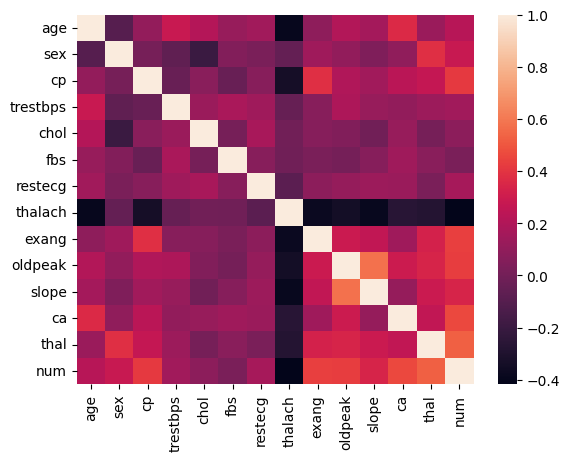

In [29]:
sns.heatmap(corr)

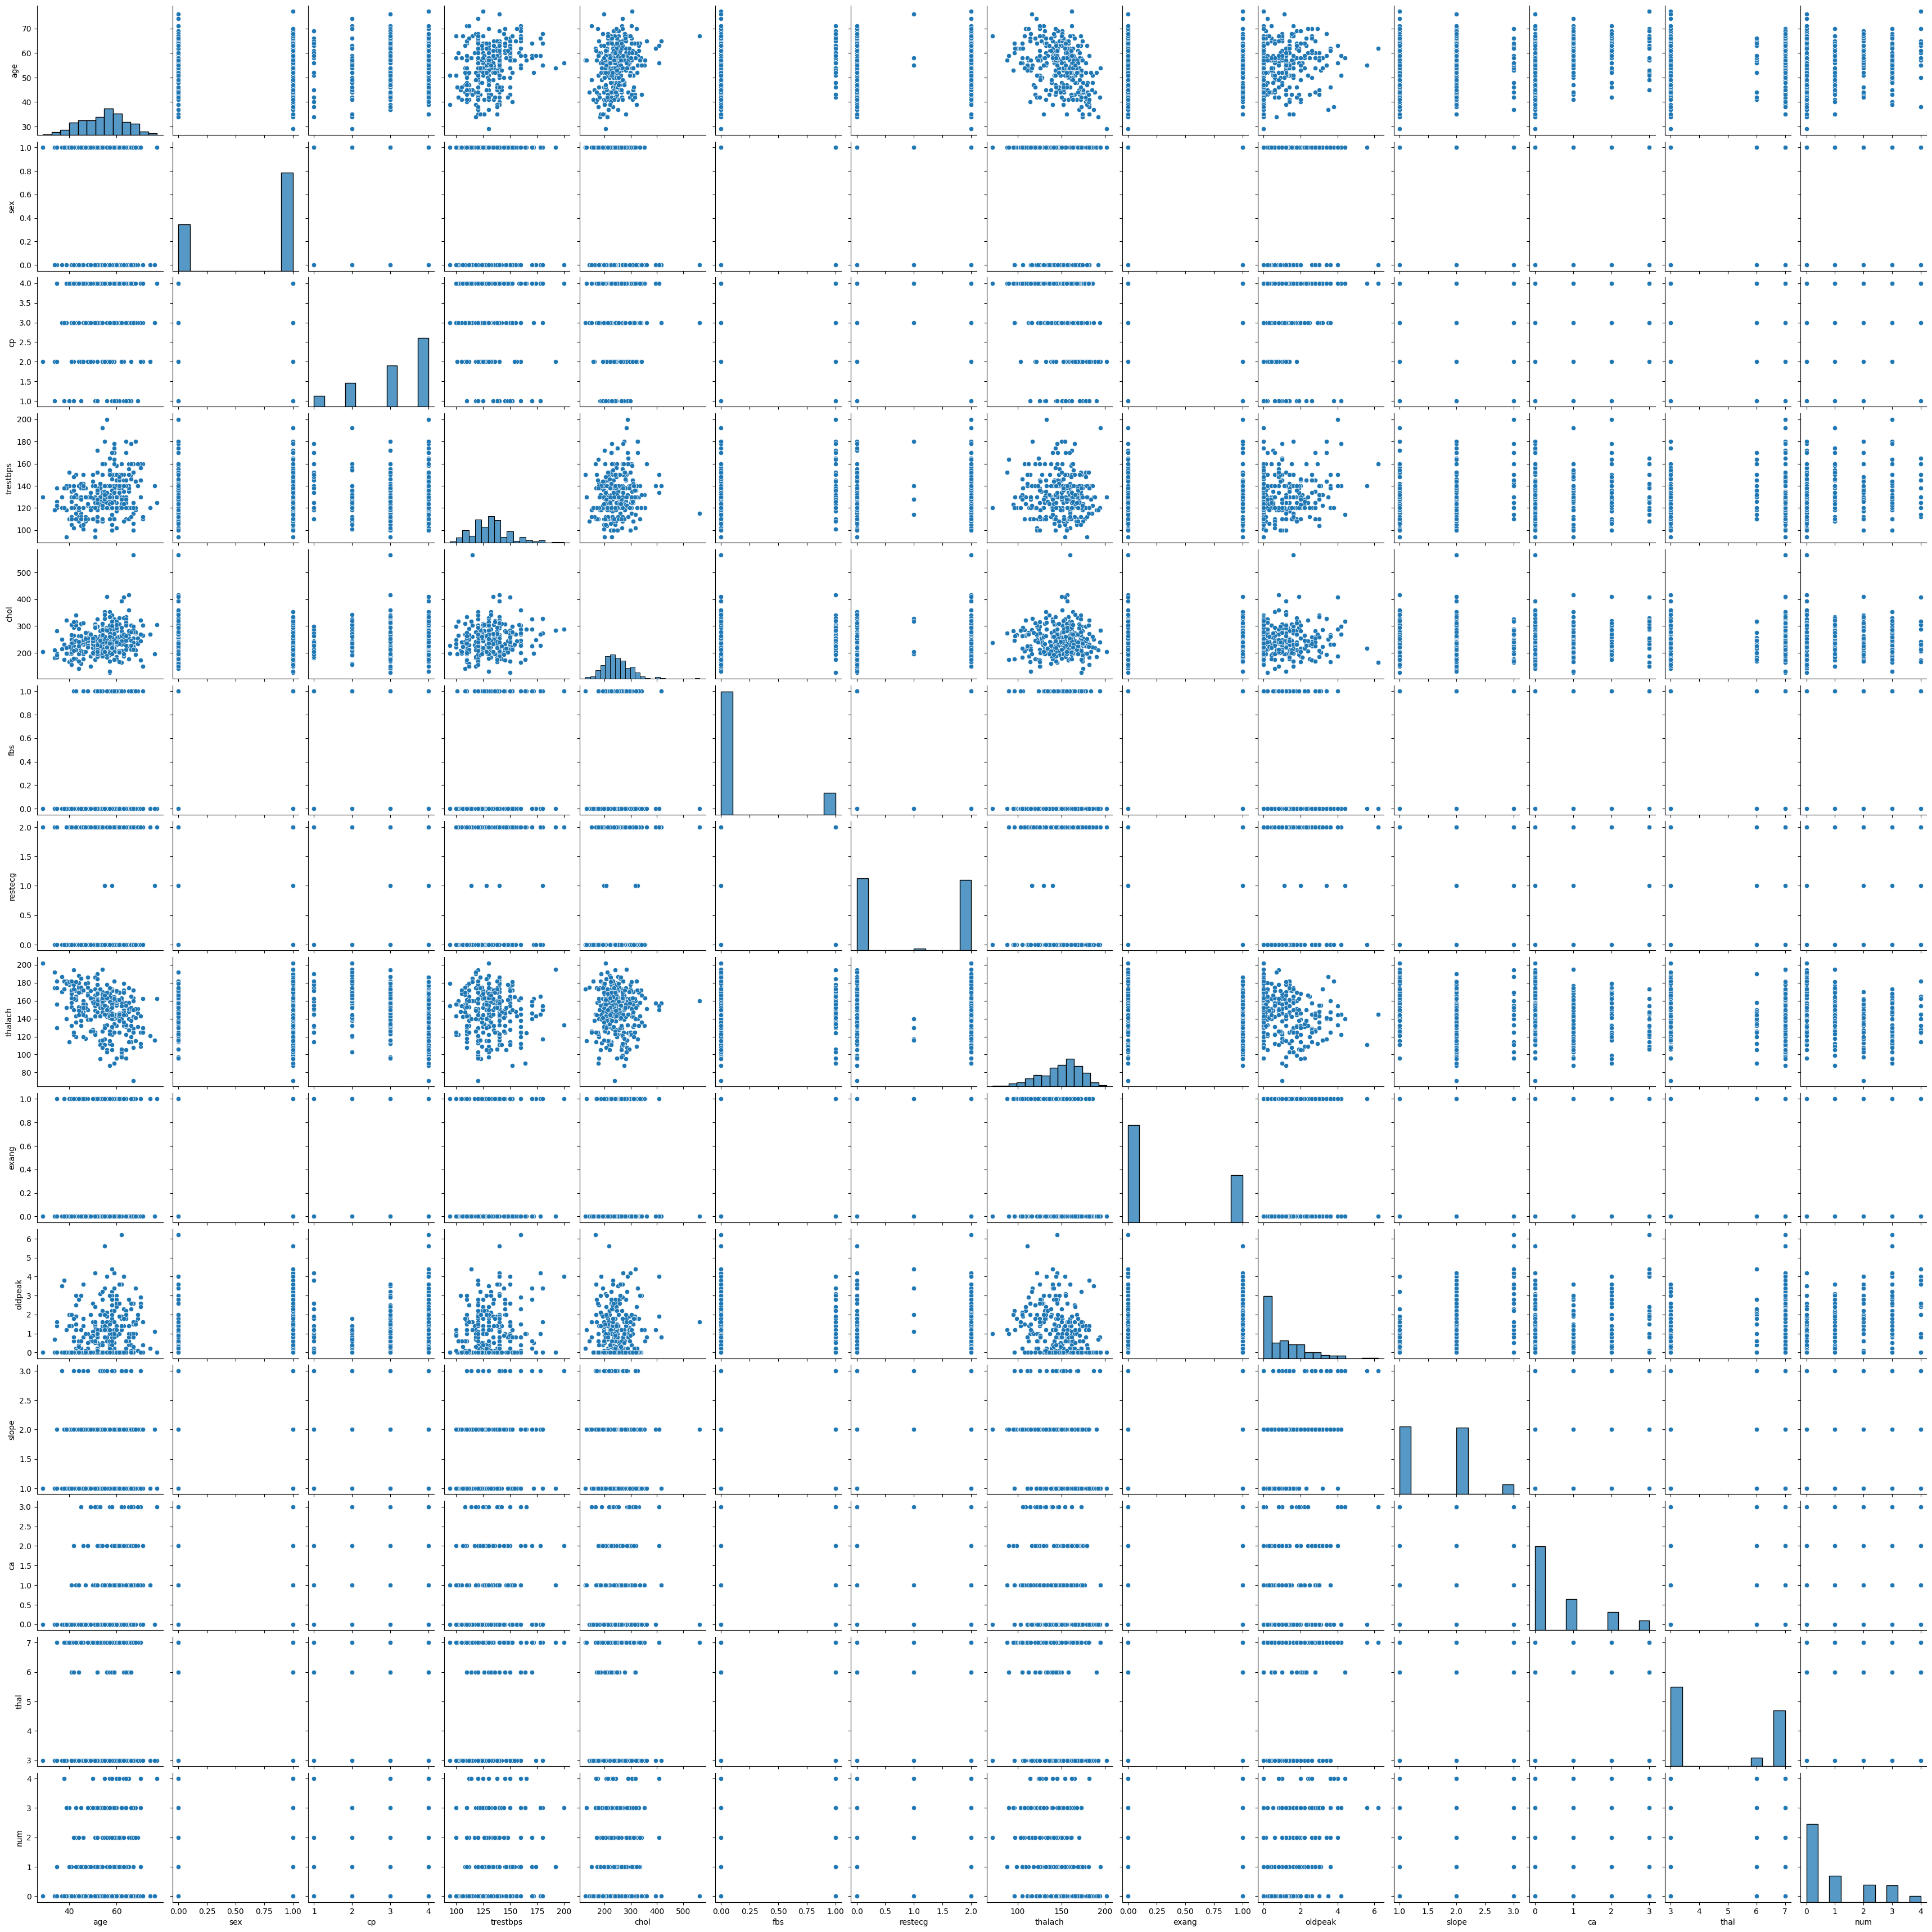

In [51]:
sns.pairplot(df)

In [30]:
null_mask = X_train.isnull().any(axis=1)
null_rows = X_train[null_mask]
null_rows

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0


In [31]:
len(null_rows)/303 *100

1.65016501650165

Since we have 6 rows with missing values, there are few ways to handle such situations:

1- Drop the rows as they only represent 2% of the dataset

2- Replace the missing values in thal column with the mode/median value as the column is categorical and replace the missing values in ca column with the mean value as it contains continuous values (using SimpleImputer function from sklearn)

3- Use more advanced techniques like KNN

In [32]:
knnImpCopy = KNNImputer(weights="distance")

In [33]:
X_copy= X_train.copy()
X_copy=pd.DataFrame(knnImpCopy.fit_transform(X_copy))
X_copy.columns = X_train.columns

In [34]:
X_copy[X_copy.isnull().any(axis=1)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal


In [35]:
pca = PCA()
pca.fit(X_copy)

PCA()

In [36]:
pca.explained_variance_ratio_

array([7.46356155e-01, 1.46375543e-01, 8.85191357e-02, 1.65386324e-02,
       1.01536926e-03, 3.45502740e-04, 2.55983001e-04, 2.33737551e-04,
       1.77962562e-04, 5.53044690e-05, 5.30121577e-05, 4.12866244e-05,
       3.23747924e-05])

<BarContainer object of 13 artists>

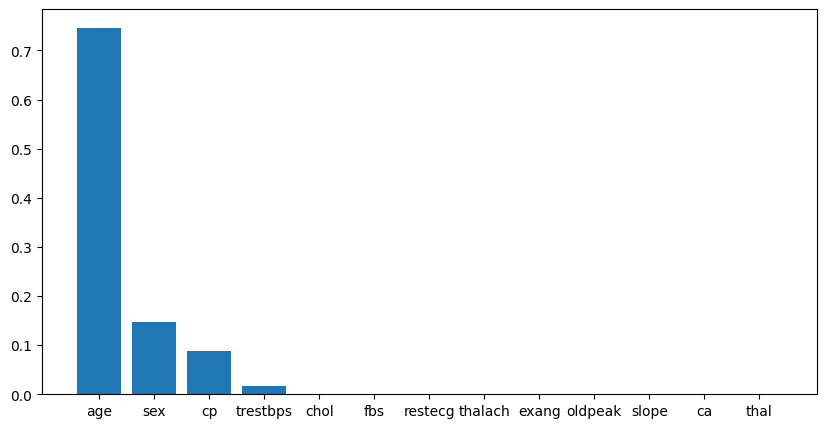

In [37]:
plt.figure(figsize = (10, 5))
plt.bar(X_copy.columns,pca.explained_variance_ratio_)

pca shows that age and sex have the highest variance ratios

In [38]:
np.array(y_train["num"])

array([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1], dtype=int64)

In [39]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_copy,np.array(y_train["num"]))

LinearDiscriminantAnalysis()

In [40]:
lda.explained_variance_ratio_

array([1.])

<BarContainer object of 1 artists>

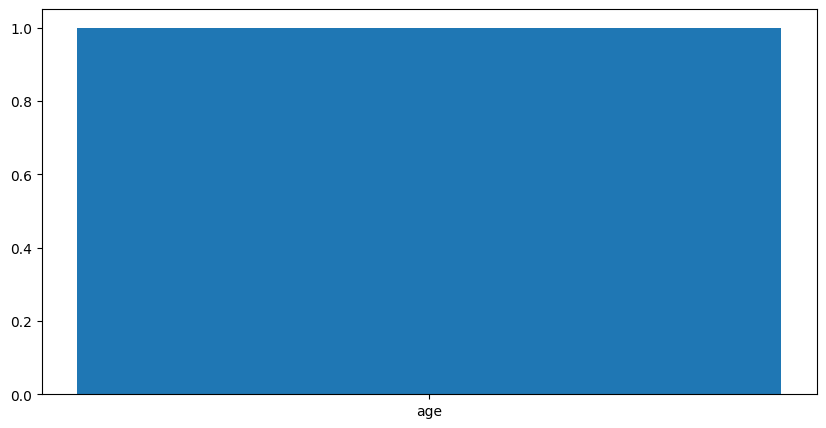

In [41]:
plt.figure(figsize = (10, 5))
plt.bar(X_copy.columns[:len(lda.explained_variance_ratio_)],lda.explained_variance_ratio_)

In [42]:
knnImp = KNNImputer(weights="distance")
categorical_columns = ["slope", "restecg", "cp","thal"]  
numeric_columns = ["age","trestbps","chol","thalach","oldpeak","ca"]  

# Define the column transformer
column_transformer = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (StandardScaler(), numeric_columns),
    remainder="passthrough"
)

def convert_to_pd_after_imp(np_arr):
    return pd.DataFrame(np_arr,columns=X.columns)
my_transformer = FunctionTransformer(convert_to_pd_after_imp)
y_train.loc[:,'num'] = y_train['num'].apply(lambda x: 1 if x in [1, 2, 3, 4] else 0)
# Create the preprocessing pipeline
data_preprocess_pipeline = make_pipeline(
    knnImp,
    my_transformer,
    column_transformer,
)
data_preprocess_pipeline

Pipeline(steps=[('knnimputer', KNNImputer(weights='distance')),
                ('functiontransformer',
                 FunctionTransformer(func=<function convert_to_pd_after_imp at 0x0000011A6EE46560>)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['slope', 'restecg', 'cp',
                                                   'thal']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak',
                                                   'ca'])]))])

In [43]:
X_transformed = data_preprocess_pipeline.fit_transform(X_train)
transformed_feature_names = data_preprocess_pipeline.named_steps['columntransformer'].get_feature_names_out()
print(transformed_feature_names)
X_transformed_train = pd.DataFrame(X_transformed,columns=transformed_feature_names) 
X_transformed_train.head()

['onehotencoder__slope_1.0' 'onehotencoder__slope_2.0'
 'onehotencoder__slope_3.0' 'onehotencoder__restecg_0.0'
 'onehotencoder__restecg_1.0' 'onehotencoder__restecg_2.0'
 'onehotencoder__cp_1.0' 'onehotencoder__cp_2.0' 'onehotencoder__cp_3.0'
 'onehotencoder__cp_4.0' 'onehotencoder__thal_3.0'
 'onehotencoder__thal_3.6372673915075318'
 'onehotencoder__thal_5.24518614755498' 'onehotencoder__thal_6.0'
 'onehotencoder__thal_7.0' 'standardscaler__age'
 'standardscaler__trestbps' 'standardscaler__chol'
 'standardscaler__thalach' 'standardscaler__oldpeak' 'standardscaler__ca'
 'remainder__sex' 'remainder__fbs' 'remainder__exang']


,onehotencoder__slope_1.0,onehotencoder__slope_2.0,onehotencoder__slope_3.0,onehotencoder__restecg_0.0,onehotencoder__restecg_1.0,onehotencoder__restecg_2.0,onehotencoder__cp_1.0,onehotencoder__cp_2.0,onehotencoder__cp_3.0,onehotencoder__cp_4.0,...,onehotencoder__thal_7.0,standardscaler__age,standardscaler__trestbps,standardscaler__chol,standardscaler__thalach,standardscaler__oldpeak,standardscaler__ca,remainder__sex,remainder__fbs,remainder__exang
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.970689,0.190395,0.091769,0.999744,-0.876964,-0.734544,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,-0.590943,0.133796,0.462577,0.553151,-0.876964,-0.734544,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.859144,-0.092596,0.306447,-2.349701,0.160893,0.330702,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.639960,1.605349,-0.259522,-0.831286,-0.790476,0.330702,1.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.859144,1.039368,-0.064360,0.195877,0.333870,-0.734544,0.0,0.0,1.0


In [45]:
X_transformed_train['onehotencoder__thal_3.6372673915075318'].value_counts()

onehotencoder__thal_3.6372673915075318
0.0    271
1.0      1
Name: count, dtype: int64

In [46]:
len(X_transformed_train)

272

In [49]:


X_transformed_train.drop(X_transformed_train[X_transformed_train['onehotencoder__thal_3.6372673915075318'] == 1].index, inplace=True)
X_transformed_train.drop(X_transformed_train[X_transformed_train['onehotencoder__thal_5.24518614755498'] == 1].index, inplace=True)
X_transformed_train = X_transformed_train.drop(['onehotencoder__thal_3.6372673915075318','onehotencoder__thal_5.24518614755498'],axis=1)

In [50]:
X_transformed_train.columns

Index(['onehotencoder__slope_1.0', 'onehotencoder__slope_2.0',
       'onehotencoder__slope_3.0', 'onehotencoder__restecg_0.0',
       'onehotencoder__restecg_1.0', 'onehotencoder__restecg_2.0',
       'onehotencoder__cp_1.0', 'onehotencoder__cp_2.0',
       'onehotencoder__cp_3.0', 'onehotencoder__cp_4.0',
       'onehotencoder__thal_3.0', 'onehotencoder__thal_6.0',
       'onehotencoder__thal_7.0', 'standardscaler__age',
       'standardscaler__trestbps', 'standardscaler__chol',
       'standardscaler__thalach', 'standardscaler__oldpeak',
       'standardscaler__ca', 'remainder__sex', 'remainder__fbs',
       'remainder__exang'],
      dtype='object')

In [51]:
X_transformed_train[X_transformed_train.isnull().any(axis=1)]

,onehotencoder__slope_1.0,onehotencoder__slope_2.0,onehotencoder__slope_3.0,onehotencoder__restecg_0.0,onehotencoder__restecg_1.0,onehotencoder__restecg_2.0,onehotencoder__cp_1.0,onehotencoder__cp_2.0,onehotencoder__cp_3.0,onehotencoder__cp_4.0,...,onehotencoder__thal_7.0,standardscaler__age,standardscaler__trestbps,standardscaler__chol,standardscaler__thalach,standardscaler__oldpeak,standardscaler__ca,remainder__sex,remainder__fbs,remainder__exang


In [52]:
len(X_transformed_train)

270

In [53]:
train_df = pd.concat([X_transformed_train,y_train],axis=1)
train_df.head()

,onehotencoder__slope_1.0,onehotencoder__slope_2.0,onehotencoder__slope_3.0,onehotencoder__restecg_0.0,onehotencoder__restecg_1.0,onehotencoder__restecg_2.0,onehotencoder__cp_1.0,onehotencoder__cp_2.0,onehotencoder__cp_3.0,onehotencoder__cp_4.0,...,standardscaler__age,standardscaler__trestbps,standardscaler__chol,standardscaler__thalach,standardscaler__oldpeak,standardscaler__ca,remainder__sex,remainder__fbs,remainder__exang,num
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.970689,0.190395,0.091769,0.999744,-0.876964,-0.734544,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.590943,0.133796,0.462577,0.553151,-0.876964,-0.734544,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.859144,-0.092596,0.306447,-2.349701,0.160893,0.330702,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.639960,1.605349,-0.259522,-0.831286,-0.790476,0.330702,1.0,1.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.859144,1.039368,-0.064360,0.195877,0.333870,-0.734544,0.0,0.0,1.0,0.0


<BarContainer object of 2 artists>

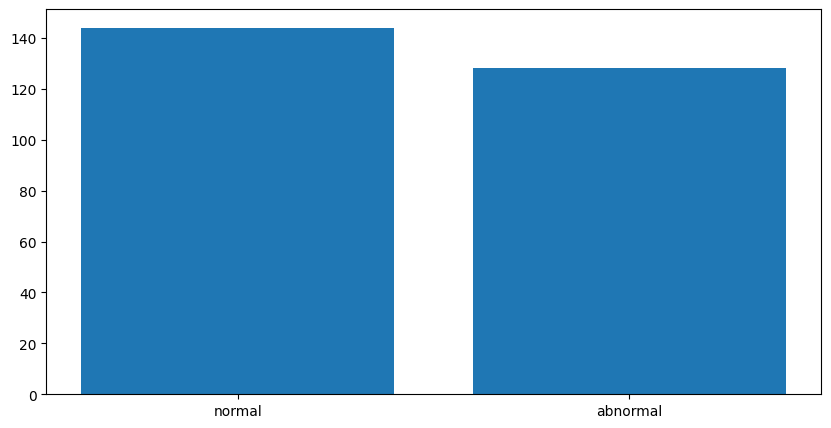

In [54]:
plt.figure(figsize=(10,5))
plt.bar(["normal","abnormal"],y_train.value_counts())

In [55]:
X_transformed_test = data_preprocess_pipeline.transform(X_test)
transformed_feature_names_test = data_preprocess_pipeline.named_steps['columntransformer'].get_feature_names_out()
X_transformed_test = pd.DataFrame(X_transformed_test,columns=transformed_feature_names_test) 

missing_columns = set(X_transformed_train.columns) - set(X_transformed_test.columns)

for column in missing_columns:
    X_transformed_test[column] = 0

# Optionally, re-order the columns of X_transformed_test to match X_transformed_train
X_transformed_test = X_transformed_test[X_transformed_train.columns]
X_transformed_test.head()

,onehotencoder__slope_1.0,onehotencoder__slope_2.0,onehotencoder__slope_3.0,onehotencoder__restecg_0.0,onehotencoder__restecg_1.0,onehotencoder__restecg_2.0,onehotencoder__cp_1.0,onehotencoder__cp_2.0,onehotencoder__cp_3.0,onehotencoder__cp_4.0,...,onehotencoder__thal_7.0,standardscaler__age,standardscaler__trestbps,standardscaler__chol,standardscaler__thalach,standardscaler__oldpeak,standardscaler__ca,remainder__sex,remainder__fbs,remainder__exang
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.524508,-0.318989,-0.571781,-0.697308,1.025775,0.330702,1.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.412963,1.039368,0.443060,-1.724471,-0.185059,-0.734544,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,-0.925579,0.360189,-0.083877,0.106558,-0.876964,-0.734544,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,-1.148669,0.473386,-0.240006,1.357018,-0.876964,-0.734544,1.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.412963,-0.375587,-0.532749,-0.250716,-0.531012,0.548189,1.0,0.0,0.0


In [56]:
X_transformed_test.columns==X_transformed_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [57]:
test_df = pd.concat([X_transformed_test,y_test],axis=1)

## Combine 2 datasets

In [119]:
num_structured_features = len(X_transformed_train.columns)

In [128]:
def combine_ds(normal_images,abnormal_images,preprocessed_df,num_images_per_record=5):
    combined_data = []

    for _, row in preprocessed_df.iterrows():
        label = row['num']
        if label == 0:
            selected_images = random.sample(normal_images, num_images_per_record)
        else:
            selected_images = random.sample(abnormal_images, num_images_per_record)

        for img in selected_images:
            combined_data.append((row.iloc[:-1], img, label))
    random.shuffle(combined_data)
    return combined_data

In [129]:
combined_train_data = combine_ds(normal_train_images,abnormal_train_images,train_df)

In [130]:
len(combined_train_data)

1495

In [131]:
combined_test_data = combine_ds(normal_test_images,abnormal_test_images,test_df)

In [132]:
def create_generator(combined_data):
    def generator():
        for row, img, label in combined_data:
            structured_data = row.to_numpy()
            yield (structured_data, img), label
    return generator

# Create specific generator functions for training and testing
train_generator = create_generator(combined_train_data)
test_generator = create_generator(combined_test_data)

In [133]:
# Adjust output_types and output_shapes to match the structure yielded by the generator
train_ds = tf.data.Dataset.from_generator(
    train_generator,
    output_types=((tf.float32, tf.float32), tf.int32),
    output_shapes=(((num_structured_features,), (224, 224, 3)), ())  # Adjust the shapes to match your data
)

test_ds = tf.data.Dataset.from_generator(
    test_generator,
    output_types=((tf.float32, tf.float32), tf.int32),
    output_shapes=(((num_structured_features,), (224, 224, 3)), ())  # Adjust the shapes to match your data
)

In [134]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [135]:
train_ds

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 22), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          1.          1.          0.
  0.          0.74759847 -0.09259631  1.6140316   0.8657658  -0.8769641
 -0.7345438   0.          0.          0.        ], shape=(22,), dtype=float32)


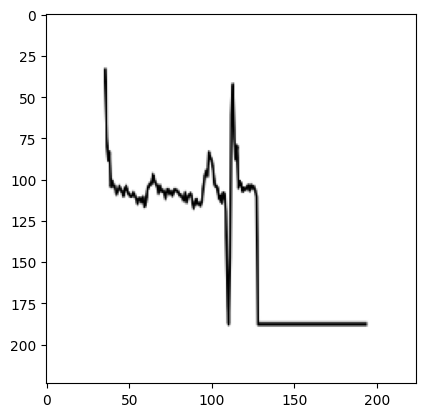

In [136]:
for inp,label in train_ds.unbatch():
    record, image = inp
    print(label)
    print(record)
    plt.imshow(image)
    break

### Data Augmentation

In [137]:
def augment_image(image, label):
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    image = tf.add(image, noise)

    return image, label

In [138]:
def apply_augmentation(inp, label):
    structured_data, image = inp
    image, label = augment_image(image, label)
    return (structured_data, image), label

In [139]:
train_ds = train_ds.map(apply_augmentation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(
[ 1.          0.          0.          0.          0.          1.
  0.          0.          0.          1.          1.          0.
  0.          0.74759847 -0.09259631  1.6140316   0.8657658  -0.8769641
 -0.7345438   0.          0.          0.        ], shape=(22,), dtype=float32)


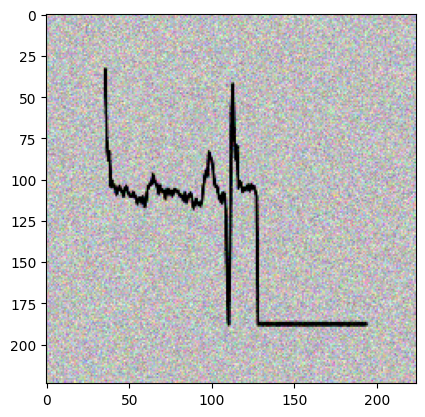

In [140]:
for inp,label in train_ds.unbatch():
    record, image = inp
    print(label)
    print(record)
    plt.imshow(image)
    break

# Multimodal model

In [142]:
# Input for structured data
structured_input = Input(shape=(num_structured_features,), name='structured_data_input')
structured_branch = Dense(64, activation='relu')(structured_input)
structured_branch = Dense(32, activation='relu')(structured_branch)

# Input for images
image_input = Input(shape=(IM_SHAPE[0], IM_SHAPE[1], 3), name='image_input')
image_branch = Conv2D(32, (3, 3), activation='relu')(image_input)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Flatten()(image_branch)

combined = concatenate([structured_branch, image_branch])
combined = Dense(64, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(combined)
model_1 = Model(inputs=[structured_input, image_input], outputs=output)

In [ ]:
model_1

In [146]:
optimizer = Adam(learning_rate=0.001)
model_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_1.fit(train_ds, epochs=10)

Epoch 1/10
12/12 [==============================] - 8s 660ms/step - loss: nan - accuracy: 0.4816
Epoch 2/10
12/12 [==============================] - 8s 654ms/step - loss: nan - accuracy: 0.4816
Epoch 3/10
12/12 [==============================] - 8s 650ms/step - loss: nan - accuracy: 0.4816
Epoch 4/10
12/12 [==============================] - 8s 666ms/step - loss: nan - accuracy: 0.4816
Epoch 5/10
12/12 [==============================] - 8s 661ms/step - loss: nan - accuracy: 0.4816
Epoch 6/10
12/12 [==============================] - 8s 667ms/step - loss: nan - accuracy: 0.4816
Epoch 7/10
12/12 [==============================] - 8s 674ms/step - loss: nan - accuracy: 0.4816
Epoch 8/10
12/12 [==============================] - 8s 669ms/step - loss: nan - accuracy: 0.4816
Epoch 9/10
12/12 [==============================] - 8s 673ms/step - loss: nan - accuracy: 0.4816
Epoch 10/10
12/12 [==============================] - 8s 667ms/step - loss: nan - accuracy: 0.4816
